In [2]:
pip install shap

  Using cached shap-0.46.0-cp39-cp39-win_amd64.whl.metadata (25 kB)
Using cached shap-0.46.0-cp39-cp39-win_amd64.whl (456 kB)
Note: you may need to restart the kernel to use updated packages.


# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import time
import shap

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.pandas.set_option('display.max_columns', 100)
pd.pandas.set_option('display.max_rows', 100)
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.simplefilter(action='ignore', category=FutureWarning)
              
sns.set()

!python --version
print('\n'.join(f'{m.__name__} {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.9.18
pandas 2.1.4
numpy 1.26.2
seaborn 0.12.2
shap 0.46.0
statsmodels.api 0.14.0


In [2]:
df = pd.read_csv('Data/df_no_wn.csv', sep=";")
df.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking(%),PropertyGFABuilding(s)(%),LargestPropertyUseType(%),SecondLargestPropertyUseType(%),ThirdLargestPropertyUseType(%),SiteEnergyUse(kBtu),SiteEnergyUse_log,TotalGHGEmissions_log,SteamUse(%),Electricity(%),NaturalGas(%),TotalGHGEmissions,Education,Food Sales,Healthcare,Industrial,Office,Parking,Recreation,Religious,Residential,Retail,Sans,Services,Warehouse,Public_Services
0,1927,1.000,12,88434,0.000,100.000,100.000,0.000,0.000,7226362.500,15.793,5.525,27.730,54.606,17.664,249.980,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,100.000,0.000,0,0.000,0.000,0.000
1,1996,1.000,11,103566,14.545,85.455,80.992,14.545,4.463,8387933.000,15.942,5.693,0.000,38.661,61.339,295.860,0.000,4.463,0.000,0.000,0.000,14.545,0.000,0.000,80.992,0.000,0,0.000,0.000,0.000
2,1969,1.000,41,956110,20.575,79.425,79.122,0.000,0.000,72587024.000,18.100,7.645,29.711,68.231,2.058,2089.280,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,79.122,0.000,0,0.000,0.000,0.000
3,1926,1.000,10,61320,0.000,100.000,100.000,0.000,0.000,6794584.000,15.732,5.661,32.591,40.752,26.657,286.430,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,100.000,0.000,0,0.000,0.000,0.000
4,1980,1.000,18,175580,35.312,64.688,70.307,38.734,0.000,14172606.000,16.467,6.227,0.000,37.880,62.120,505.010,0.000,0.000,0.000,0.000,0.000,38.734,0.000,0.000,70.307,0.000,0,0.000,0.000,0.000


In [3]:
df.columns

Index(['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)',
       'LargestPropertyUseType(%)', 'SecondLargestPropertyUseType(%)',
       'ThirdLargestPropertyUseType(%)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUse_log', 'TotalGHGEmissions_log', 'SteamUse(%)',
       'Electricity(%)', 'NaturalGas(%)', 'TotalGHGEmissions', 'Education',
       'Food Sales', 'Healthcare', 'Industrial', 'Office', 'Parking',
       'Recreation', 'Religious', 'Residential', 'Retail', 'Sans', 'Services',
       'Warehouse', 'Public_Services'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1542 entries, 0 to 1541
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   YearBuilt                        1542 non-null   int64  
 1   NumberofBuildings                1542 non-null   float64
 2   NumberofFloors                   1542 non-null   int64  
 3   PropertyGFATotal                 1542 non-null   int64  
 4   PropertyGFAParking(%)            1542 non-null   float64
 5   PropertyGFABuilding(s)(%)        1542 non-null   float64
 6   LargestPropertyUseType(%)        1542 non-null   float64
 7   SecondLargestPropertyUseType(%)  1542 non-null   float64
 8   ThirdLargestPropertyUseType(%)   1542 non-null   float64
 9   SiteEnergyUse(kBtu)              1542 non-null   float64
 10  SiteEnergyUse_log                1542 non-null   float64
 11  TotalGHGEmissions_log            1542 non-null   float64
 12  SteamUse(%)         

# Évaluation de modèles

In [5]:
features = ['YearBuilt',
           'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking(%)',
           'PropertyGFABuilding(s)(%)', 'LargestPropertyUseType(%)',
           'SecondLargestPropertyUseType(%)', 'ThirdLargestPropertyUseType(%)', 'SteamUse(%)',
           'Electricity(%)', 'NaturalGas(%)', 'Education', 'Food Sales', 'Healthcare',
           'Industrial', 'Office', 'Parking', 'Recreation', 'Religious',
           'Residential', 'Retail', 'Sans', 'Services', 'Warehouse',
           'Public_Services']

X = df[features]
y = df['SiteEnergyUse_log']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

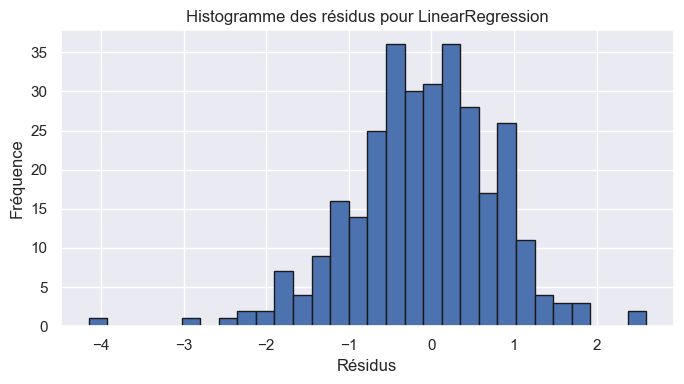

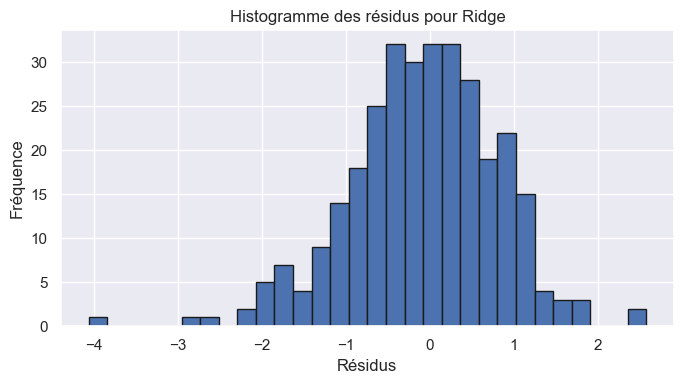

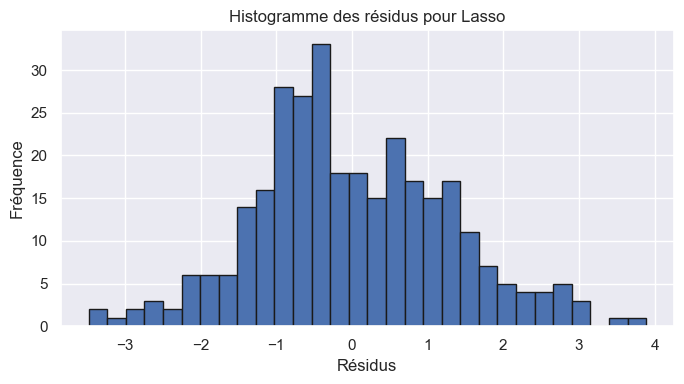

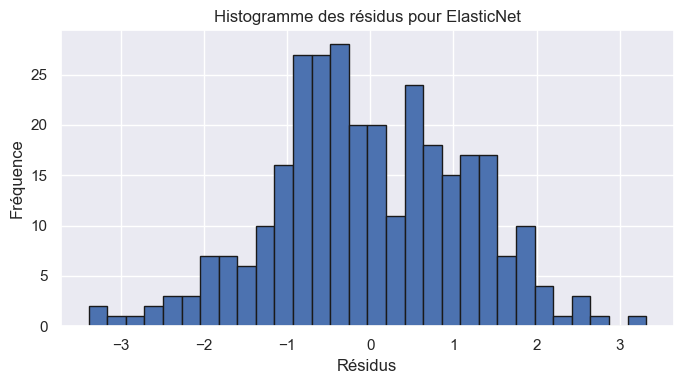

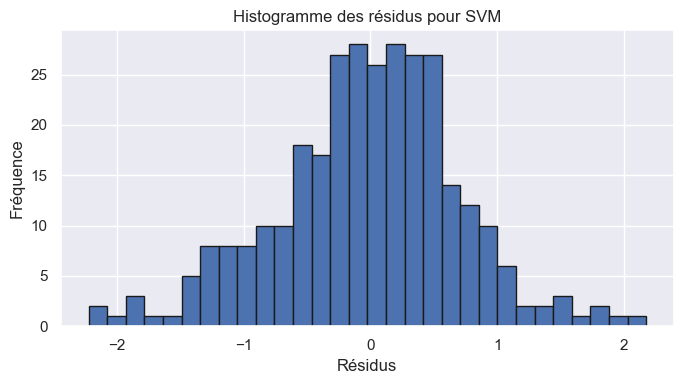

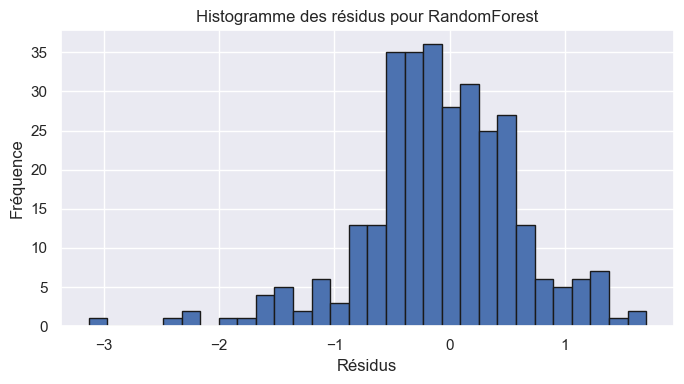

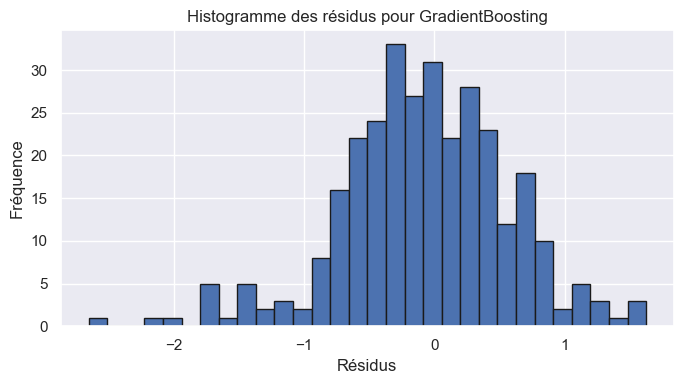

,Model,MSE,RMSE,MAE,R2,Time (s)
0,LinearRegression,0.773,0.879,0.680,0.533,0.004
1,Ridge,0.772,0.879,0.682,0.533,0.002
2,Lasso,1.654,1.286,1.035,-0.000,0.002
3,ElasticNet,1.335,1.155,0.939,0.193,0.003
4,SVM,0.528,0.726,0.559,0.681,0.074
5,RandomForest,0.466,0.682,0.509,0.719,1.263
6,GradientBoosting,0.425,0.652,0.499,0.743,0.382


In [8]:
def evaluate_models(X, y):
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # scaler = StandardScaler()
    # X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    # X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    models = {
        'LinearRegression' : LinearRegression(),
        'Ridge' : Ridge(alpha=1.0),
        'Lasso' : Lasso(alpha=1.0),
        'ElasticNet' : ElasticNet(alpha=1.0, l1_ratio=0.5),
        'SVM' : SVR(kernel='rbf', C=1.0, epsilon=0.1),
        'RandomForest' : RandomForestRegressor(n_estimators=100),
        'GradientBoosting' : GradientBoostingRegressor(n_estimators=100)
    }

    results_list = []
    residuals_dict = {}
    predictions_dict = {}
    feature_importance_dict = {}

    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train_std, y_train)
        y_pred = model.predict(X_test_std)
        end_time = time.time()

        exec_time = end_time - start_time
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Calcul des résidus
        residuals = y_test - y_pred
        residuals_dict[name] = residuals
        predictions_dict[name] = y_pred

        # Extraire et stocker les features importances
        if name in ['SVR', 'RandomForest', 'GradientBoosting']:
            feature_importance_dict[name] = model.feature_importances_

        # Affichage de l'histogramme des résidus
        plt.figure(figsize=(7, 4))
        plt.hist(residuals, bins=30, edgecolor='k')
        plt.title(f'Histogramme des résidus pour {name}')
        plt.xlabel('Résidus')
        plt.ylabel('Fréquence')
        plt.tight_layout()
        plt.show()

        results_list.append({
            'Model' : name,
            'MSE' : mse,
            'RMSE' : rmse,
            'MAE' : mae,
            'R2' : r2,
            'Time (s)' : exec_time
        })

        results = pd.DataFrame(results_list)

    return results, residuals_dict, predictions_dict, X_train_std, X_test_std, y_train, y_test, feature_importance_dict

results, residuals_dict, predictions_dict, X_train_std, X_test_std, y_train, y_test, feature_importance_dict = evaluate_models(X, y)
results

Les premiers résultats nous indiquent que les modèles de régressions classique ne sont pas forcément efficace pour ce jeu de données. A l'inverse, les modèles RandomForest et GradientBoosting offrent des résultats de base assez efficaces pour un début.

## Analyse des résidus

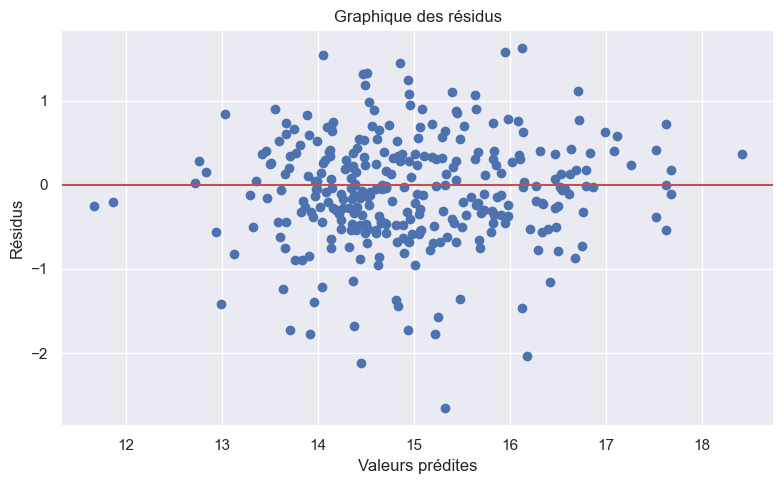

In [9]:
model_name = 'GradientBoosting'
residuals = residuals_dict[model_name]
y_test_pred = predictions_dict[model_name]

plt.figure(figsize=(8, 5))
plt.scatter(y_test_pred, residuals)
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphique des résidus")
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
plt.show()

## Validation croisée

In [10]:
param_grid = {
    'n_estimators' : [100, 200, 300],
    'learning_rate' : [0.1, 0.05, 0.01],
    'max_depth' : [2, 4, 5],
    'min_samples_split' : [2, 4, 5],
    'min_samples_leaf' : [2, 4, 5]
}

grid_search = GridSearchCV(estimator=GradientBoostingRegressor(),
                         param_grid=param_grid,
                         cv=5,
                         n_jobs=-1,
                         verbose=2,
                         scoring='neg_mean_squared_error')

grid_search.fit(X_train_std, y_train)

best_params = grid_search.best_params_
print(f"Les meilleurs paramètres sont : {best_params}")

best_score = np.sqrt(-grid_search.best_score_)
print(f"Le meilleur score RMSE est : {best_score}")

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_std)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Les meilleurs paramètres sont : {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 200}
Le meilleur score RMSE est : 0.6935265483030997


In [11]:
best_gb_model = GradientBoostingRegressor(**best_params)
best_gb_model.fit(X_train_std, y_train)
y_test_pred_best = best_gb_model.predict(X_test_std)

mse_best = mean_squared_error(y_test, y_test_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_test_pred_best)
r2_score_best = r2_score(y_test, y_test_pred_best)

results_best_gb = pd.DataFrame({
    'Model' : ['GradientBoosting (best params)'],
    'MSE' : [mse_best],
    'RMSE' : [rmse_best],
    'MAE' : [mae_best],
    'R2' : [r2_score_best]
})

results_best_gb

,Model,MSE,RMSE,MAE,R2
0,GradientBoosting (best params),0.405,0.637,0.479,0.755


On peut voir que ça reste un score similaire au modèle GradientBoosting de base. Il n'y a pas de réel changement significatif avec la validation croisée.

## Features Importances

### Globale

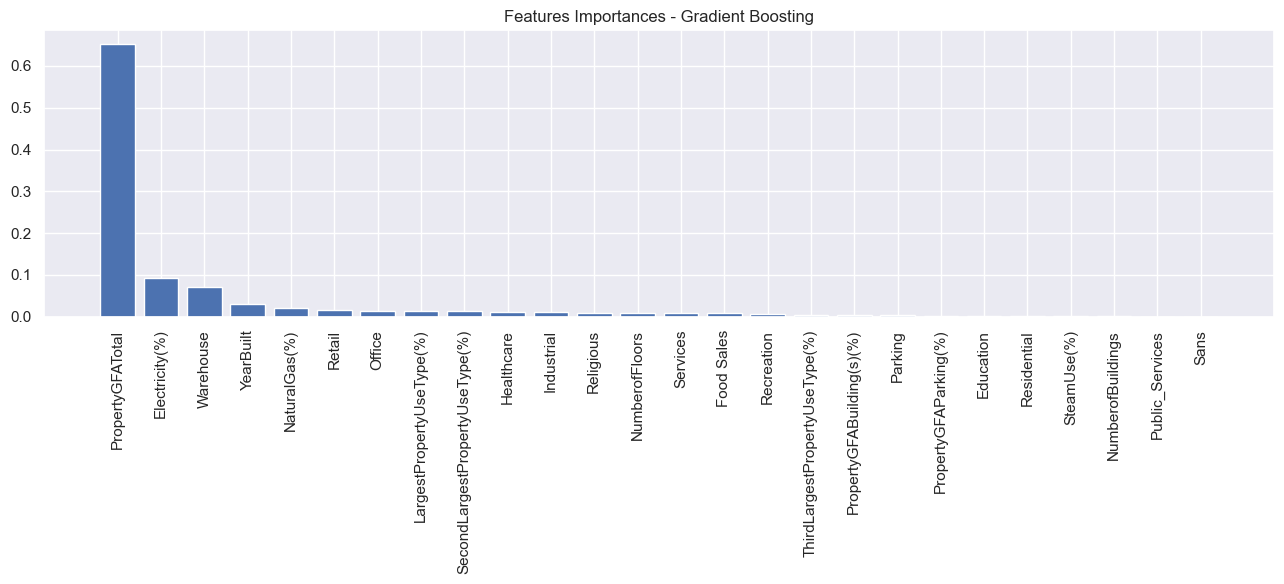

In [12]:
# Extraction des features importances
feature_importances = best_gb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(13, 6))
plt.title("Features Importances - Gradient Boosting")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

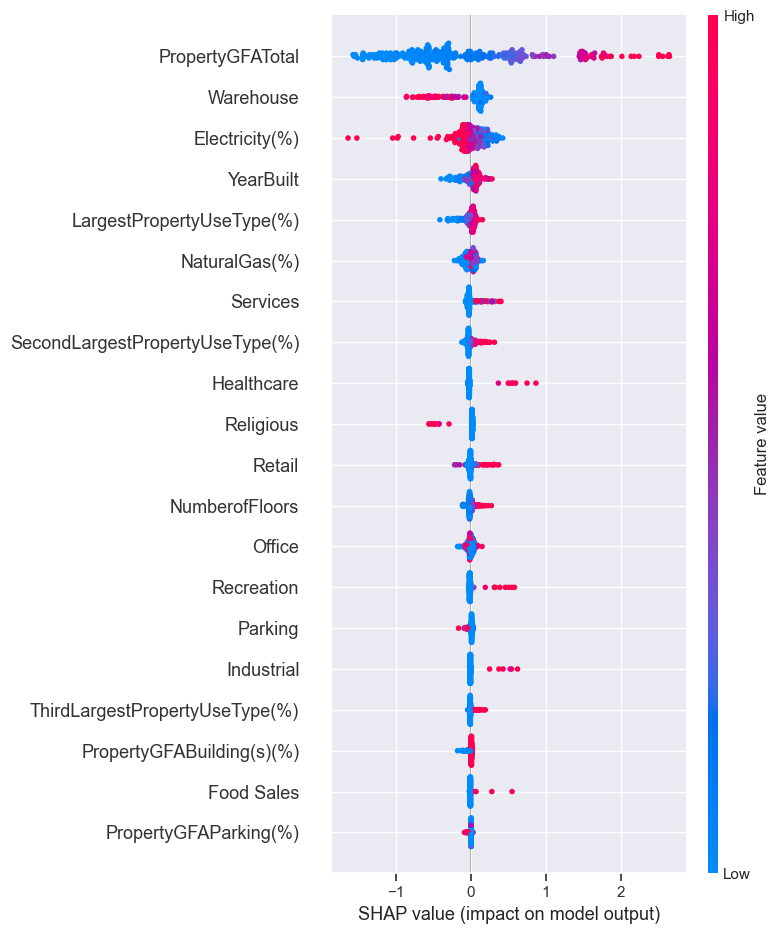

In [13]:
# Initialisation de l'objet "Explainer" concernant le modèle d'entrainement gradient boosting
explainer = shap.Explainer(best_gb_model, X_train_std)

# Calcule les valeurs SHAP qui quantifient l'importance de chaque variable pour chaque prédiction
shap_values = explainer(X_test_std)

# Génère le graphique des valeurs SHAP pour voir l'importance moyenne des variables sur le test
shap.summary_plot(shap_values, X_test_std, feature_names=X_train.columns)

### Locale

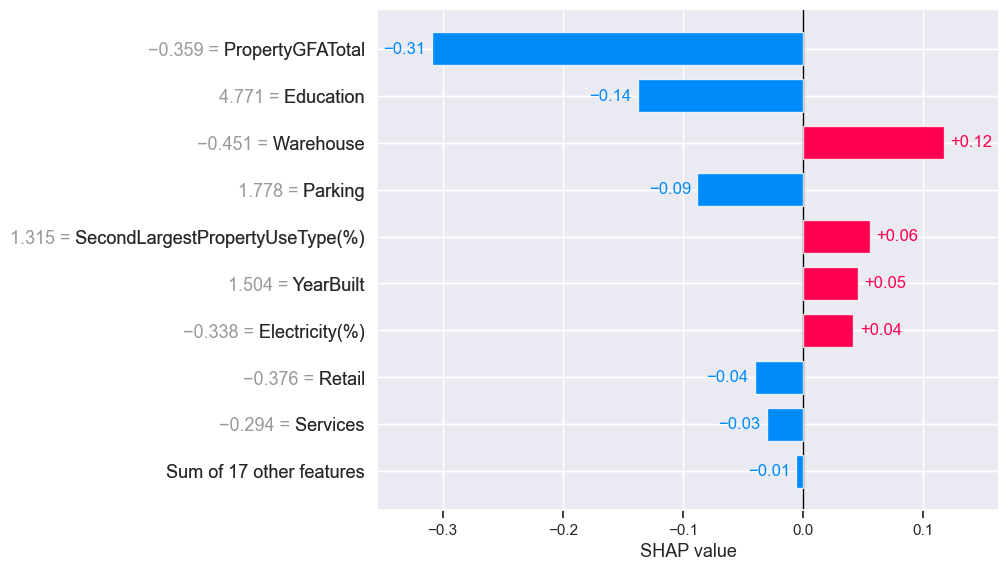

In [14]:
shap.plots.bar(shap_values[0])

In [15]:
datacenter_index_train = X_test.loc[X_test['PropertyGFATotal'] == 172842].index[0]
office_index_test = X_test.loc[X_test['PropertyGFATotal'] == 52554].index[0]
hospital_index_test = X_test.loc[X_test['PropertyGFATotal'] == 597519].index[0]

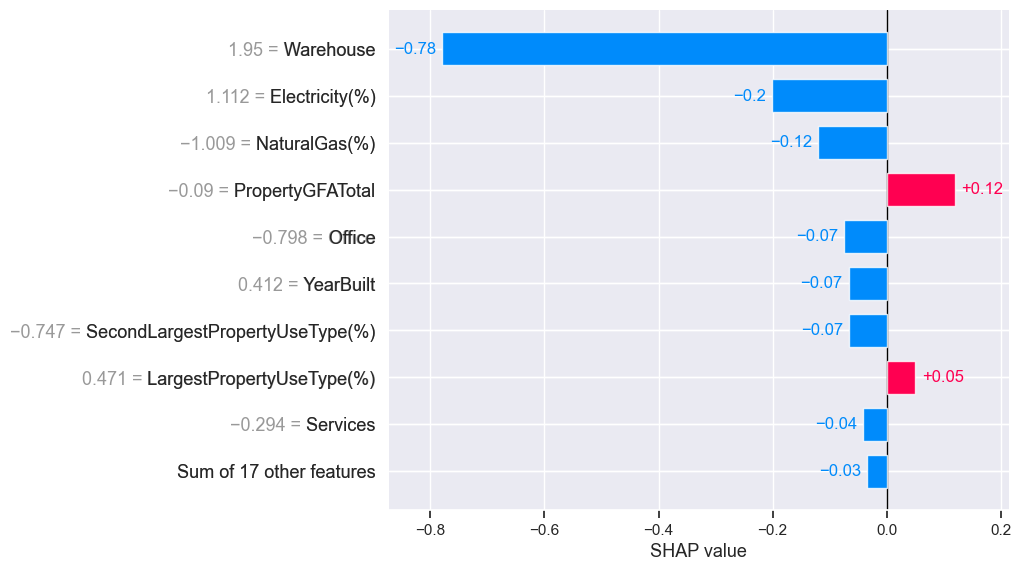

In [16]:
shap.plots.bar(shap_values[office_index_test])

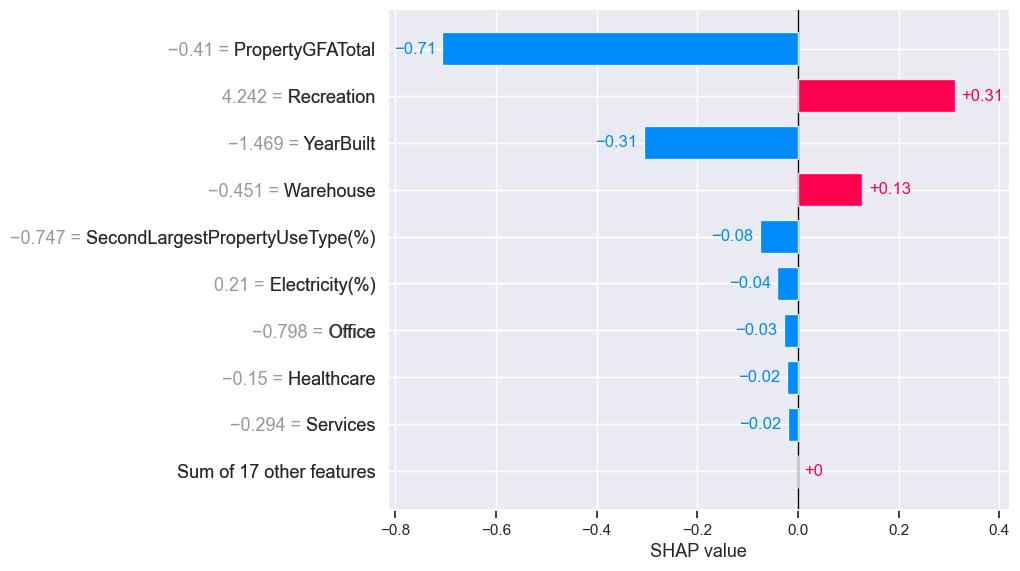

In [17]:
shap.plots.bar(shap_values[hospital_index_test])

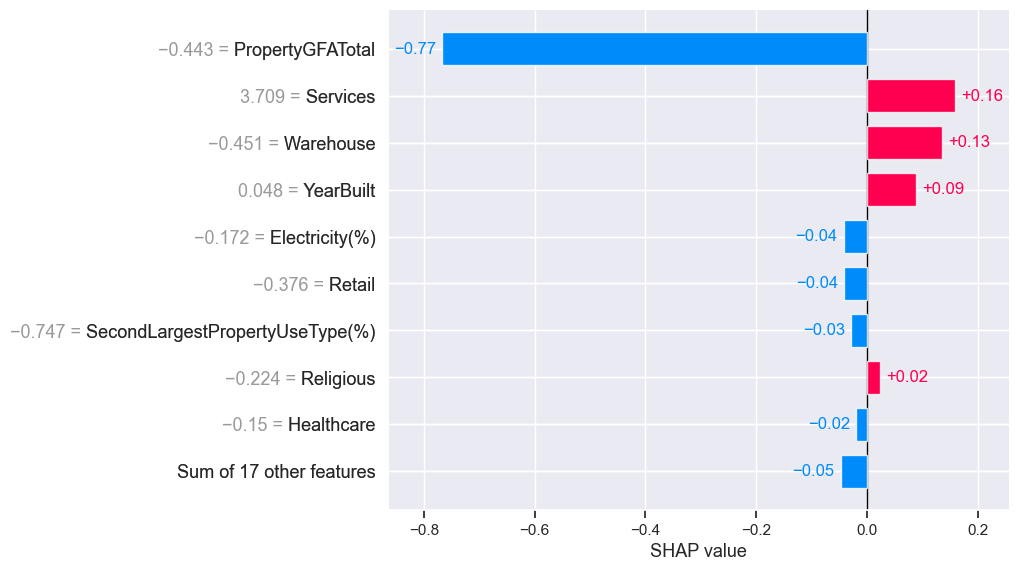

In [18]:
shap.plots.bar(shap_values[datacenter_index_train])

# ENERGYStarScore

Passons le jeu de données avec l'ENERGYSTARScore aux différents algorithmes pour voir si cette variable est significative. Pour rappel, il y a moins de données dans celui-ci (1006 contre 1542 pour celui sans l'ENERGYSTARScore).

In [19]:
df_star_score = pd.read_csv('Data/df_star_score.csv', sep=";")
df_star_score.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking(%),PropertyGFABuilding(s)(%),LargestPropertyUseType(%),SecondLargestPropertyUseType(%),ThirdLargestPropertyUseType(%),SiteEnergyUse(kBtu),SiteEnergyUse_log,TotalGHGEmissions_log,SteamUse(%),Electricity(%),NaturalGas(%),ENERGYSTARScore,TotalGHGEmissions,Education,Food Sales,Healthcare,Industrial,Office,Parking,Recreation,Religious,Residential,Retail,Sans,Services,Warehouse,Public_Services
0,1927,1.000,12,88434,0.000,100.000,100.000,0.000,0.000,7226362.500,15.793,5.525,27.730,54.606,17.664,60.000,249.980,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,100.000,0.000,0,0.000,0.000,0.000
1,1996,1.000,11,103566,14.545,85.455,80.992,14.545,4.463,8387933.000,15.942,5.693,0.000,38.661,61.339,61.000,295.860,0.000,4.463,0.000,0.000,0.000,14.545,0.000,0.000,80.992,0.000,0,0.000,0.000,0.000
2,1969,1.000,41,956110,20.575,79.425,79.122,0.000,0.000,72587024.000,18.100,7.645,29.711,68.231,2.058,43.000,2089.280,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,79.122,0.000,0,0.000,0.000,0.000
3,1926,1.000,10,61320,0.000,100.000,100.000,0.000,0.000,6794584.000,15.732,5.661,32.591,40.752,26.657,56.000,286.430,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,100.000,0.000,0,0.000,0.000,0.000
4,1980,1.000,18,175580,35.312,64.688,70.307,38.734,0.000,14172606.000,16.467,6.227,0.000,37.880,62.120,75.000,505.010,0.000,0.000,0.000,0.000,0.000,38.734,0.000,0.000,70.307,0.000,0,0.000,0.000,0.000


In [20]:
df_star_score.columns

Index(['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)',
       'LargestPropertyUseType(%)', 'SecondLargestPropertyUseType(%)',
       'ThirdLargestPropertyUseType(%)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUse_log', 'TotalGHGEmissions_log', 'SteamUse(%)',
       'Electricity(%)', 'NaturalGas(%)', 'ENERGYSTARScore',
       'TotalGHGEmissions', 'Education', 'Food Sales', 'Healthcare',
       'Industrial', 'Office', 'Parking', 'Recreation', 'Religious',
       'Residential', 'Retail', 'Sans', 'Services', 'Warehouse',
       'Public_Services'],
      dtype='object')

In [21]:
features = ['YearBuilt', 'NumberofBuildings',
           'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking(%)',
           'PropertyGFABuilding(s)(%)', 'LargestPropertyUseType(%)',
           'SecondLargestPropertyUseType(%)', 'ThirdLargestPropertyUseType(%)',
           'ENERGYSTARScore',
           'SteamUse(%)', 'Electricity(%)', 'NaturalGas(%)','Education', 'Food Sales', 'Healthcare',
           'Industrial', 'Office', 'Parking', 'Recreation', 'Religious',
           'Residential', 'Retail', 'Sans', 'Services', 'Warehouse',
           'Public_Services']

X_star_score = df_star_score[features]
y_star_score = df_star_score['SiteEnergyUse_log']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_star_score, y_star_score, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

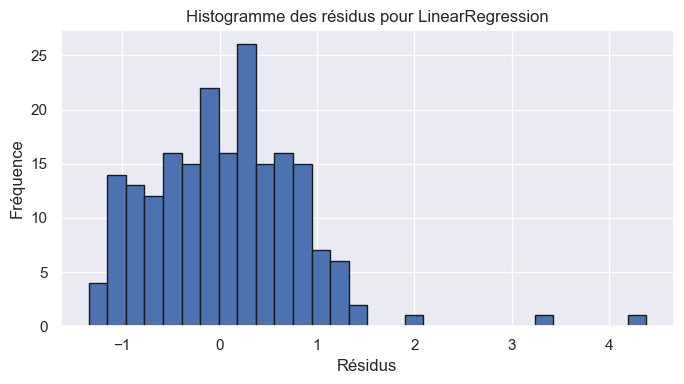

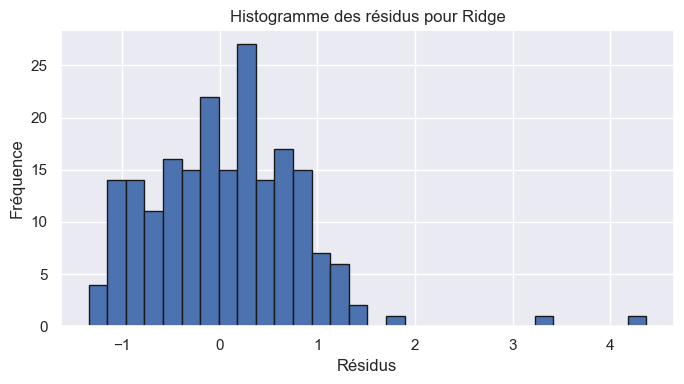

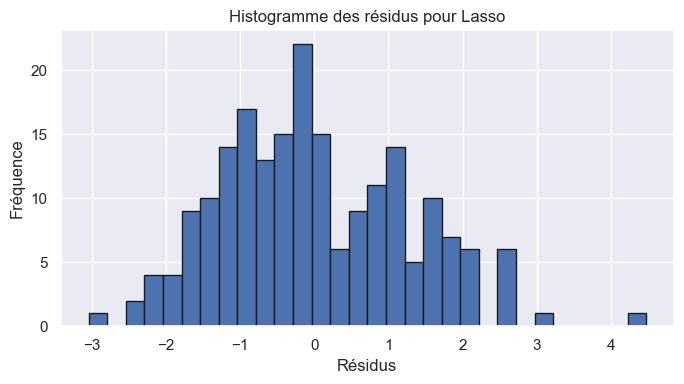

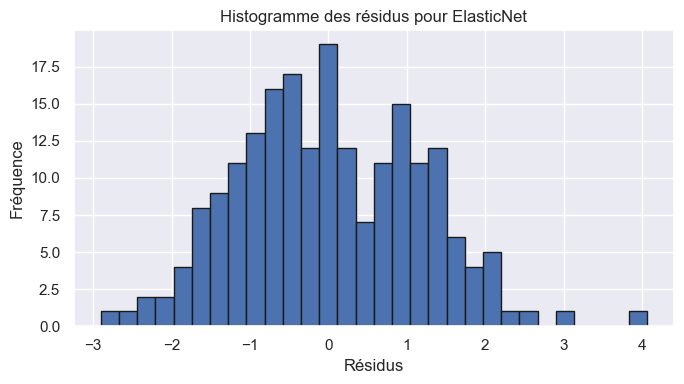

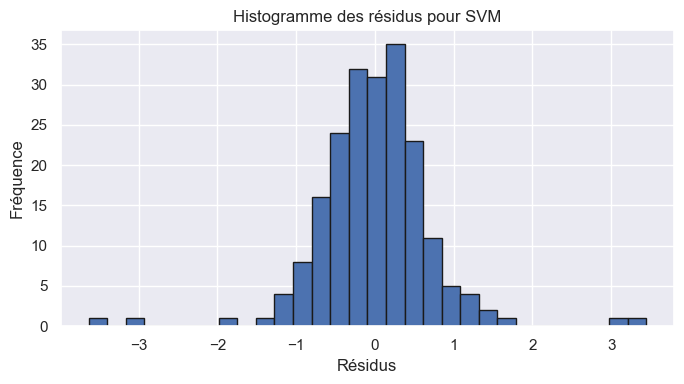

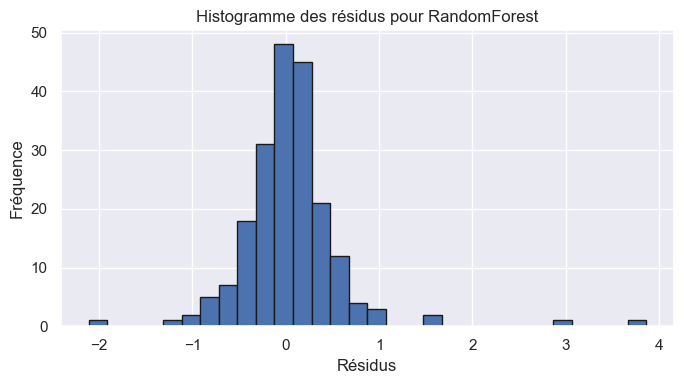

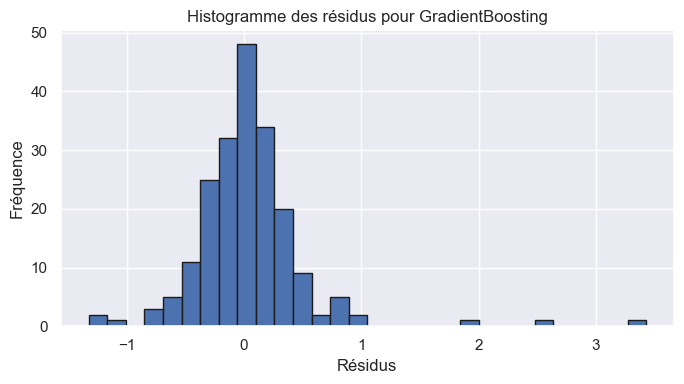

,Model,MSE,RMSE,MAE,R2,Time (s)
0,LinearRegression,0.590,0.768,0.586,0.633,0.003
1,Ridge,0.590,0.768,0.586,0.633,0.003
2,Lasso,1.607,1.268,1.030,-0.000,0.004
3,ElasticNet,1.339,1.157,0.941,0.167,0.003
4,SVM,0.526,0.725,0.499,0.673,0.038
5,RandomForest,0.292,0.540,0.334,0.818,0.834
6,GradientBoosting,0.231,0.480,0.293,0.856,0.281


In [23]:
results, residuals_dict, predictions_dict, X_train_std, X_test_std, y_train, y_test, feature_importance_dict = evaluate_models(X_star_score, y_star_score)
results

On peut percevoir une amélioration de plusieurs modèles, dont celui du GradientBoosting qui atteint les 0.85 (soit 10 de plus que le modèle sans ENERGYSTARScore).

### Features importances

#### Globale

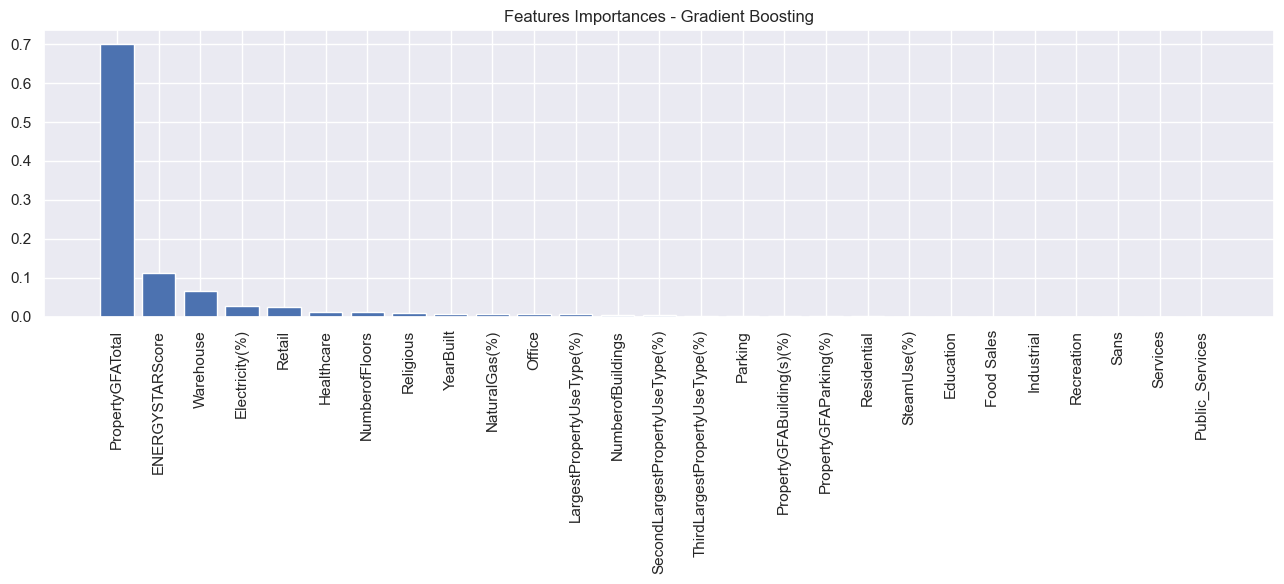

In [24]:
# Extraction des features importances
feature_importances = feature_importance_dict['GradientBoosting']
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(13, 6))
plt.title("Features Importances - Gradient Boosting")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

Ce qui serait intéressant de voir, c'est est-ce que si on enlève cette variable, on aura d'aussi bons résultats? Est-ce que les 1006 individus sont suffisants pour atteindre un bon score ou les 1542 sont quand même plus importants par rapport au nombre?

In [25]:
features = ['YearBuilt', 'NumberofBuildings',
           'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking(%)',
           'PropertyGFABuilding(s)(%)', 'LargestPropertyUseType(%)',
           'SecondLargestPropertyUseType(%)', 'ThirdLargestPropertyUseType(%)',
           'SteamUse(%)', 'Electricity(%)', 'NaturalGas(%)','Education', 'Food Sales', 'Healthcare',
           'Industrial', 'Office', 'Parking', 'Recreation', 'Religious',
           'Residential', 'Retail', 'Sans', 'Services', 'Warehouse',
           'Public_Services']

X_new = df_star_score[features]
y_new = df_star_score['SiteEnergyUse_log']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

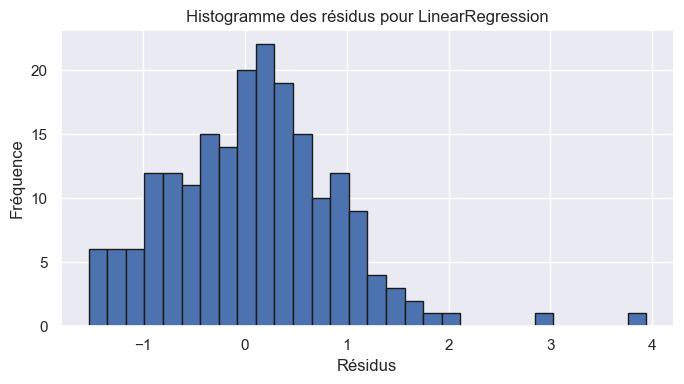

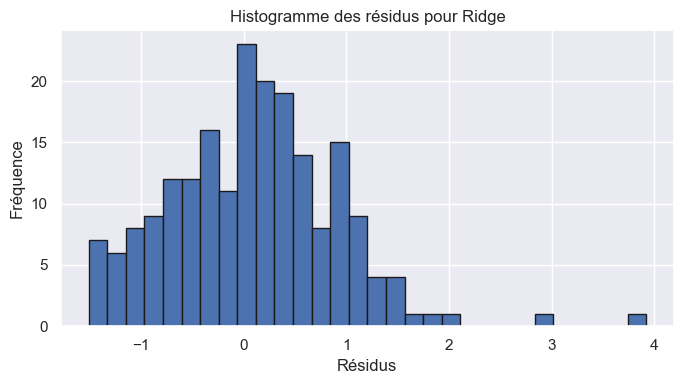

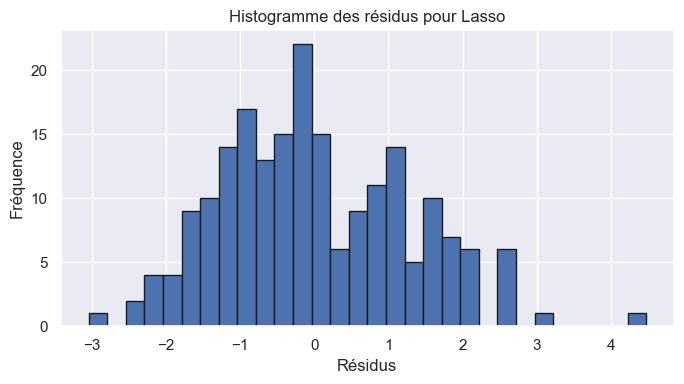

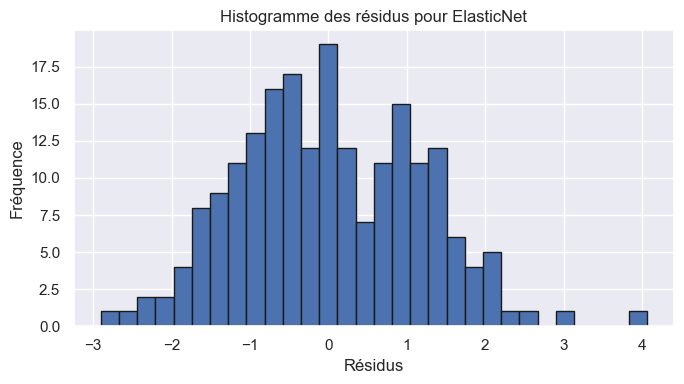

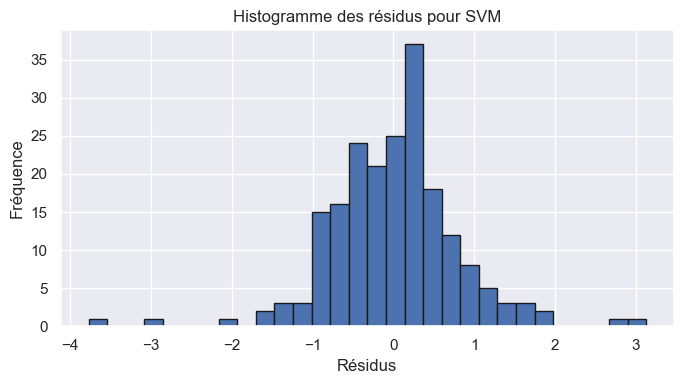

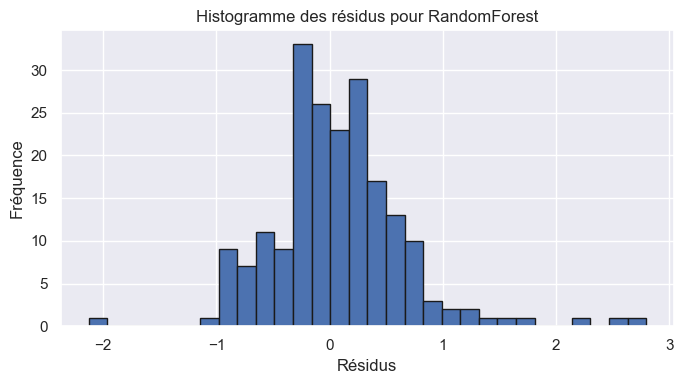

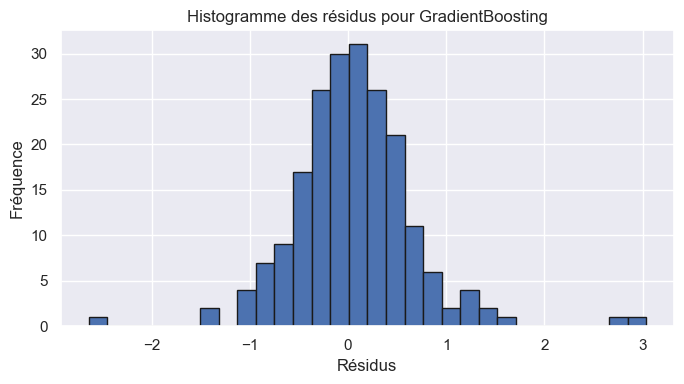

,Model,MSE,RMSE,MAE,R2,Time (s)
0,LinearRegression,0.670,0.819,0.636,0.583,0.004
1,Ridge,0.673,0.820,0.638,0.582,0.002
2,Lasso,1.607,1.268,1.030,-0.000,0.003
3,ElasticNet,1.339,1.157,0.941,0.167,0.002
4,SVM,0.650,0.806,0.581,0.595,0.034
5,RandomForest,0.365,0.604,0.431,0.773,0.784
6,GradientBoosting,0.378,0.615,0.432,0.765,0.263


In [28]:
results, residuals_dict, predictions_dict, X_train_std, X_test_std, y_train, y_test, feature_importance_dict = evaluate_models(X_new, y_new)
results

On voit tout de même une différence sur les modèles qui nous intéressent (RandomForest et GradientBoosting). La variable ENERGYStarScore augmente donc la pertinence de nos meilleurs modèles sur ce jeu de données réduit.